In [185]:
# Install dependencies
!pip install -r ../requirements.txt

In [186]:
import sys
import os
# Add the parent directory to the path
sys.path.append(os.path.abspath('..'))

In [187]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from data.stockData import get_stock_data
from data.visualiserData import plot_stock_metric, plot_metric_across_stocks, plot_interactive_metric_across_stocks, plot_predictions_true_and_actual
from utility.colors import generate_bright_random_color
from features.featureExtractor import calculate_moving_average, calculate_bollinger_bands
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import plotly.graph_objects as go


In [188]:
# Fetch stock data
# tickers = ['AAPL', 'GOOGL']
tickers = ['META', 'ADBE', 'MA', 'GS', 'NFLX', 'LMT', 'MCD']
start_date = '2023-01-01'
# start_date = '2017-01-01'
end_date = '2024-01-01'
ticker_dict = {}

In [229]:
# from dotenv import dotenv_values
# config = dotenv_values(".env") 
# plotly_api_key = config['plotly_studio_api']
# plotly_studio_username = config['plotly_studio_username']

# This is a sample api key, which is no longer working, please generate one
chart_studio.tools.set_credentials_file(username=plotly_studio_username,
                                        api_key=plotly_api_key)



# fig = evaluate_model_sequence3(model, test_sequence_loader, wandb_log = False, days_back_to_plot = 30)
# py.plot(fig, filename="FinanceEP01_SequencerEvaluator_30", auto_open = True)


In [189]:
config = {
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32,
    "tickers" : tickers,
    "start_date" : start_date,
    "end_date" : end_date,
    "model_name": "NeuralNetSimple_v5",
    "percentage_sequence_test_days" : 0.2,
    "percentage_test" : 0.2
}

In [190]:
# Intialising wandb ideally you should run this after wandb.login()
wandb.init(project="stock-price-prediction", name=f"{config['model_name']}_{config['epochs']}e", config = config)
wandb.config.update(config)


In [191]:
stock_data = get_stock_data(tickers, start_date, end_date)

Loaded data from cache for tickers: ['META', 'ADBE', 'MA', 'GS', 'NFLX', 'LMT', 'MCD']


In [192]:
# stock_data['AAPL'].tail()

In [193]:
# Apply feature engineering
for ticker, df in stock_data.items():
    df['SMA_5'] = calculate_moving_average(df, window=5)
    df['MA_20'], df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df, window=10)
    

In [194]:
stock_data[tickers[0]].tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,MA_20,Upper_Band,Lower_Band
Date,,,,,,,,,,
2023-12-22,355.579987,357.200012,351.220001,353.390015,352.329163,11764200,350.347998,341.407001,361.661224,321.152777
2023-12-26,354.989990,356.980011,353.450012,354.829987,353.764832,9898600,352.389996,344.362000,362.689898,326.034101
2023-12-27,356.070007,359.000000,355.309998,357.829987,356.755829,13207900,353.883997,346.722998,365.325090,328.120906
2023-12-28,359.700012,361.899994,357.809998,358.320007,357.244354,11798800,355.691998,349.081000,366.893374,331.268625
2023-12-29,358.989990,360.000000,351.820007,353.959991,352.897491,14980500,355.665997,351.159998,365.164827,337.155169


In [195]:
# # Apply feature engineering and visualize the data
# for ticker, df in stock_data.items():
#     df['SMA_5'] = calculate_moving_average(df, window=5)
#     df['MA_20'], df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df, window=20)
    
#     # Plot the data for each ticker
#     plot_stock_data(df, ticker)

In [196]:
stock_data

{'META':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2023-01-03  122.820000  126.370003  122.279999  124.739998  124.365540   
 2023-01-04  127.379997  129.050003  125.849998  127.370003  126.987656   
 2023-01-05  126.129997  128.520004  124.540001  126.940002  126.558945   
 2023-01-06  128.970001  130.330002  126.040001  130.020004  129.629700   
 2023-01-09  131.160004  132.949997  129.279999  129.470001  129.081345   
 ...                ...         ...         ...         ...         ...   
 2023-12-22  355.579987  357.200012  351.220001  353.390015  352.329163   
 2023-12-26  354.989990  356.980011  353.450012  354.829987  353.764832   
 2023-12-27  356.070007  359.000000  355.309998  357.829987  356.755829   
 2023-12-28  359.700012  361.899994  357.809998  358.320007  357.244354   
 2023-12-29  358.989990  360.000000  351.820007  353.959991  352.897491   
 
               

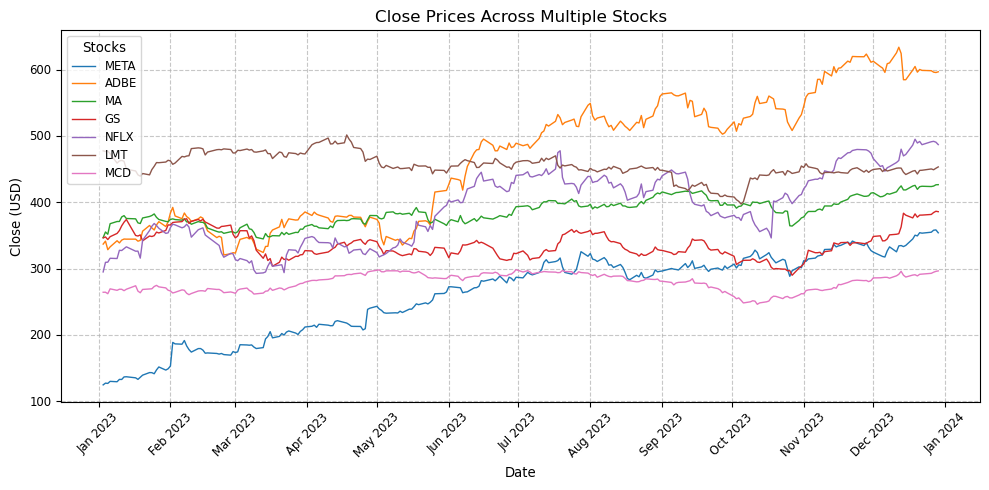

In [197]:
# Plot Close prices for all stocks
plot_metric_across_stocks(stock_data, 'Close', figsize=(10, 5))

In [198]:
 fig = plot_interactive_metric_across_stocks(stock_data, 'Close')

In [199]:
py.plot(fig, filename="FinanceEP01_closePrice_30", auto_open = True)

'https://plotly.com/~jerryfinance/13/'

# Data Preparation

In [200]:
# Initialize an empty dictionary for ticker-to-integer mapping
ticker_dict = {}
ticker_counter = 0  # Start counter for assigning integer values

def get_ticker_value(ticker):
    global ticker_dict, ticker_counter
    
    # If ticker is not already in the dictionary, add it
    if ticker not in ticker_dict:
        ticker_dict[ticker] = ticker_counter
        ticker_counter += 1
    
    # Return the integer value for the ticker
    return ticker_dict[ticker]

In [201]:

def prepare_data(df, ticker):
    """
    Prepares the features and target with a 1-day shift in the target (Close price).
    Adds a ticker column with the specified ticker value and performs one-hot encoding for it.
    """
    ticker_dict = {}

    # Features: 'SMA_5', 'MA_20', 'Upper_Band', 'Lower_Band', 'Close', 'Volume'
    features = df[['SMA_5', 'MA_20', 'Upper_Band', 'Lower_Band', 'Close', 'Volume']].copy()

    # Get the integer value for the ticker from the dictionary
    ticker_encoded = get_ticker_value(ticker)

    # Add the ticker integer value as a new column
    features['Ticker'] = ticker_encoded
    
    # Target: Tomorrow's Close price (shifted by -1)
    target = df['Close'].shift(-1)

    # Concatenate features and target into a single DataFrame for consistent row dropping
    combined = pd.concat([features, target], axis=1)
    combined.columns = list(features.columns) + ['Target']

    # Drop rows where any NaNs exist in features or target
    combined = combined.dropna()

    # Split back into features and target
    features = combined.iloc[:, :-1]  # All columns except the last
    target = combined.iloc[:, -1]     # The last column is the target (next day's Close)

    return features, target

In [202]:
# Prepare features and target for each stock
all_features, all_targets = [], []
for ticker, df in stock_data.items():
    features, target = prepare_data(df, ticker)
    all_features.append(features)
    all_targets.append(target)

In [203]:
all_features[1]

,SMA_5,MA_20,Upper_Band,Lower_Band,Close,Volume,Ticker
Date,,,,,,,
2023-01-17,342.986005,339.643005,350.588768,328.697243,344.380005,2512700,1
2023-01-18,343.508002,340.082004,350.893702,329.270306,341.309998,2079800,1
2023-01-19,343.428003,340.194003,351.089721,329.298286,342.529999,2467000,1
2023-01-20,345.796002,342.988004,354.780246,331.195761,356.380005,3149400,1
2023-01-23,349.916003,346.211005,362.374510,330.047499,364.980011,3187100,1
...,...,...,...,...,...,...,...
2023-12-21,596.930005,606.242004,640.075704,572.408305,600.140015,3192800,1
2023-12-22,599.744006,605.116003,639.141299,571.090708,598.750000,1659800,1
2023-12-26,599.570007,602.422003,633.519931,571.324075,598.260010,1595100,1


In [204]:
# Combine all stocks into a single dataset
X = pd.concat(all_features)
y = pd.concat(all_targets)


In [205]:

# Assume that X originally has a date/index column
date_index = X.index  # Save the date index separately

# Normalize the data using MinMaxScaler (exclude the date/index column)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors (after scaling)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Prepare for concatenation across all stocks
X_train_all, X_test_all, X_sequential_test_all = [], [], []
y_train_all, y_test_all, y_sequential_test_all = [], [], []
date_train_all, date_test_all, date_sequential_test_all = [], [], []

# Length of data for one stock
one_stock_length = len(all_features[0])

# Loop through each ticker and process its data
for index, ticker in enumerate(tickers):
    # Split the stock data for current ticker
    start_index = one_stock_length * index
    end_index = one_stock_length * (index + 1)
    
    X_stock = X_tensor[start_index:end_index]
    y_stock = y_tensor[start_index:end_index]
    date_stock = date_index[start_index:end_index]

    # Train-Test split (80% train, 20% test) without shuffling
    X_train_stock, X_test_temp_stock, y_train_stock, y_test_temp_stock, date_train_stock, date_test_temp_stock = train_test_split(
        X_stock, y_stock, date_stock, test_size=wandb.config.percentage_test, random_state=42, shuffle=False
    )
    
    # Shuffle only the training data
    train_size = len(X_train_stock)
    indices = torch.randperm(train_size).numpy()  # Create random indices to shuffle
    X_train_stock = X_train_stock[indices]  # Shuffle training features
    y_train_stock = y_train_stock[indices]  # Shuffle training labels
    date_train_stock = date_train_stock[indices]  # Shuffle training dates

    # Sequential Test Split (taking the last 20% of the test data for sequential testing)
    sequential_test_size_stock = int(len(X_test_temp_stock) * wandb.config.percentage_sequence_test_days)

    # Regular Test Set (80% of test data for regular testing)
    X_test_stock = X_test_temp_stock[:-sequential_test_size_stock]
    y_test_stock = y_test_temp_stock[:-sequential_test_size_stock]
    date_test_stock = date_test_temp_stock[:-sequential_test_size_stock]

    # Sequential Test Set (last 20% of the test data for sequential testing)
    X_sequential_test_stock = X_test_temp_stock[-sequential_test_size_stock:]
    y_sequential_test_stock = y_test_temp_stock[-sequential_test_size_stock:]
    date_sequential_test_stock = date_test_temp_stock[-sequential_test_size_stock:]

    # Collect data for this ticker
    X_train_all.append(X_train_stock)
    y_train_all.append(y_train_stock)
    date_train_all.append(date_train_stock)

    X_test_all.append(X_test_stock)
    y_test_all.append(y_test_stock)
    date_test_all.append(date_test_stock)

    X_sequential_test_all.append(X_sequential_test_stock)
    y_sequential_test_all.append(y_sequential_test_stock)
    date_sequential_test_all.append(date_sequential_test_stock)

    print(f"{ticker} processed (Index: {index})")


META processed (Index: 0)
ADBE processed (Index: 1)
MA processed (Index: 2)
GS processed (Index: 3)
NFLX processed (Index: 4)
LMT processed (Index: 5)
MCD processed (Index: 6)


In [206]:
aa = torch.tensor(date_train_all[0].astype('int64') // 10**9, dtype=torch.float32)
bb = torch.cat([torch.tensor(date_index.astype('int64') // 10**9, dtype=torch.int32) for date_index in date_train_all])


In [207]:
# Concatenate all the individual ticker data back together

# Keep in mind that Unix timestamps in seconds will exceed this range in the future (after 2038).
# If you are storing dates far into the future or past, consider using int64 instead.
X_train = torch.cat(X_train_all, dim=0)
y_train = torch.cat(y_train_all, dim=0)
date_train = torch.cat([torch.tensor(date_index.astype('int64') // 10**9, dtype=torch.int32) for date_index in date_train_all])

X_test = torch.cat(X_test_all, dim=0)
y_test = torch.cat(y_test_all, dim=0)
date_test = torch.cat([torch.tensor(date_index.astype('int64') // 10**9, dtype=torch.int32) for date_index in date_test_all])

X_sequential_test = torch.cat(X_sequential_test_all, dim=0)
y_sequential_test = torch.cat(y_sequential_test_all, dim=0)
date_sequential_test = torch.cat([torch.tensor(date_index.astype('int64') // 10**9, dtype=torch.int32) for date_index in date_sequential_test_all])

# Create DataLoader for mini-batches
train_dataset = TensorDataset(X_train, y_train, date_train)
test_dataset = TensorDataset(X_test, y_test, date_test)
test_sequence_dataset = TensorDataset(X_sequential_test, y_sequential_test, date_sequential_test)

train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=wandb.config.batch_size, shuffle=False)
# the sequence batch size is for 1 stock per patch
test_sequence_loader = DataLoader(test_sequence_dataset, batch_size=(int)(y_sequential_test.shape[0]/len(wandb.config.tickers)), shuffle=False)

In [208]:
print("Stats")
print("Length of train data", X_train.shape)
print("Length of test data", X_test.shape)
print("Length of sequencial test data", X_sequential_test.shape)
print("Number of Stocks", len(tickers))


Stats
Length of train data torch.Size([1344, 7])
Length of test data torch.Size([273, 7])
Length of sequencial test data torch.Size([63, 7])
Number of Stocks 7


## Model Def

In [209]:
class StockPredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [210]:
# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = StockPredictor(input_size)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)


# Model Train and Testing

In [211]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets, dates in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)  # Calculate average loss for the epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
        # Log losses to W&B
        wandb.log({"epoch": epoch + 1, "train_loss_average": avg_loss})

In [212]:
y_train.shape

torch.Size([1344, 1])

In [213]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total_loss = 0.0
        for inputs, targets, dates in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    wandb.log({"test_loss": avg_loss})
    

In [214]:
# Train the model
train_model(model, train_loader, criterion, optimizer, wandb.config.epochs)

Epoch [1/10], Loss: 136155.4355
Epoch [2/10], Loss: 133615.5225
Epoch [3/10], Loss: 125120.3047
Epoch [4/10], Loss: 105574.8041
Epoch [5/10], Loss: 73847.6858
Epoch [6/10], Loss: 37250.6675
Epoch [7/10], Loss: 11335.3608
Epoch [8/10], Loss: 2156.4665
Epoch [9/10], Loss: 950.5323
Epoch [10/10], Loss: 863.8245


In [215]:
# Evaluate the model
evaluate_model(model, test_loader, criterion)

Test Loss: 1092.0506


In [216]:
def evaluate_model_sequence3(model, test_sequence_loader, wandb_log = True, days_back_to_plot = 30):
    # Normalizing the ticker dictionary to map ticker values to a normalized range
    normalized_ticker_dict = {ticker: round((value - min(ticker_dict.values())) / (max(ticker_dict.values()) - min(ticker_dict.values())), 4) for ticker, value in ticker_dict.items()}
    # Reverse the normalized dict to get the ticker name back from the normalized value
    ticker_reversed = {value: ticker for  ticker, value in normalized_ticker_dict.items()}

    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        results = {}
        
        # Create a Plotly figure
        fig = go.Figure()
        traces = []
        all_tickers = set()  # Set to keep track of unique tickers
        total_loss = 0.0

        # Iterate through the sequential test loader
        for inputs, targets, current_dates in test_sequence_loader:
            # Get the normalized value of the ticker from inputs and find the ticker name
            stock_ticker_key = round(inputs[0][-1].item(), 4)
            ticker_name = ticker_reversed[stock_ticker_key]
            all_tickers.add(ticker_name)  # Add ticker to the set
            
            # Convert the dates to readable format (datetime)
            dates = [datetime.fromtimestamp(ts.item()).date() for ts in current_dates]

            # Pass inputs through the model to get predictions
            outputs = model(inputs)

            # Extract true values and predicted values
            true_values = targets.cpu().numpy()
            predicted_values = outputs.cpu().numpy()

            # Determine the start date for the current prediction
            start_date = dates[0]
            actual_start_date = pd.to_datetime(start_date) - timedelta(days=days_back_to_plot)  # Ensure start_date is a datetime
            
            # Add traces for true and predicted values to a list
            color = generate_bright_random_color()

            # Extract actual values for the previous 30 days from stock_data
            ticker_data = stock_data[ticker_name]
            actual_values_df = ticker_data.loc[(ticker_data.index >= actual_start_date)]

            actual_dates = actual_values_df.index.tolist()  # Get the index as dates
            actual_values = actual_values_df['Close'].values.tolist() 


            traces.append(go.Scatter(
                x=actual_dates,
                y=actual_values,
                mode='lines',
                name=f'{ticker_name} True Values',
                line=dict(color=color)
            ))
            
            traces.append(go.Scatter(
                x=dates,
                y=predicted_values.reshape(-1),
                mode='lines',
                name=f'{ticker_name} Predictions',
                line=dict(color=color, dash='dash')
            ))

            # Calculate some loss metric (e.g., Mean Squared Error)
            mse_loss = ((true_values - predicted_values) ** 2).mean()
            total_loss += mse_loss
            
            # Log loss metric to WandB
            if wandb_log:
                wandb.log({f'{ticker_name}_mse_loss_sequential': mse_loss})
        
        if wandb_log:
            wandb.log({"avg_sequential_test_loss": total_loss/len(tickers)})
        return plot_predictions_true_and_actual(traces, tickers)


In [217]:
evaluate_model_sequence3(model, test_sequence_loader)

In [218]:
fig = evaluate_model_sequence3(model, test_sequence_loader, wandb_log = False, days_back_to_plot = 90)
# Log the Plotly figure using wandb.Plotly
wandb.log({"Sequencer Evaluator": wandb.Plotly(fig)})

In [219]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px


username='jerryfinance'
api_key='FJbG2Yfx5o7WZ5cXpBri' 
# This is a sample api key, which is no longer working, please generate one
chart_studio.tools.set_credentials_file(username=plotly_studio_username,
                                        api_key=plotly_api_key)



# fig = evaluate_model_sequence3(model, test_sequence_loader, wandb_log = False, days_back_to_plot = 30)
# py.plot(fig, filename="FinanceEP01_SequencerEvaluator_30", auto_open = True)

'https://plotly.com/~jerryfinance/15/'

In [220]:
# # Save model checkpoint to W&B, I dont want to run out of cloud nor local space :') maybe later
# torch.save(model.state_dict(), "stock_price_model.pth")
# wandb.save("stock_price_model.pth")

# Finish W&B run
wandb.finish()

ADBE_mse_loss_sequential,▁
GS_mse_loss_sequential,▁
LMT_mse_loss_sequential,▁
MA_mse_loss_sequential,▁
MCD_mse_loss_sequential,▁
META_mse_loss_sequential,▁
NFLX_mse_loss_sequential,▁
avg_sequential_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_loss,▁
train_loss_average,██▇▆▅▃▂▁▁▁


In [221]:
from dotenv import load_dotenv

In [222]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_key = os.getenv('API_KEY')

In [223]:
api_key

In [224]:
os

<module 'os' (frozen)>

'FJbG2Yfx5o7WZ5cXpBri'